In [1]:
from settings import *

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# 시작 및 종료 날짜에 대한 날짜 시간 정의
start_date = datetime(1950, 1, 1)
# end_date = datetime.datetime(2020, 9, 29)
# Yahoo Finance에서 시작일과 종료일 사이의 지정된 기간 동안 주식 데이터 가져 오기
unrate = web.DataReader("UNRATE","fred",start_date)#,end_date)

In [4]:
# %%
unrate['12ma'] = unrate.rolling(12).mean()
unrate_shifted = unrate.shift(1)
# unrate.plot()
# %%
us500 = yf.download('^GSPC')[['Adj Close']]
us500.columns = ['US500']
us500['200ma'] = us500['US500'].rolling(200).mean()
# %%
signal = bt.merge(us500, unrate_shifted)
signal = signal.fillna(method='ffill')
signal = signal['1993':].copy()
# %%
cond1 = (signal['US500'] < signal['200ma'])
cond2 = (signal['UNRATE'] > signal['12ma'])
signal['berish'] = (cond1 & cond2)
signal = signal.resample('D').fillna('ffill')

[*********************100%***********************]  1 of 1 completed


In [5]:
# %%
read_df = pd.read_csv('./data/laa_assets.csv', index_col=0, parse_dates=True)
cols = ['us500_UH', 'gold_H', 'nasdaq100_UH', 'usdkrw'] 
price_df = read_df.loc[:, cols].dropna().copy()
price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7405 entries, 1993-01-29 to 2021-12-03
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   us500_UH      7405 non-null   float64
 1   gold_H        7405 non-null   float64
 2   nasdaq100_UH  7405 non-null   float64
 3   usdkrw        7405 non-null   float64
dtypes: float64(4)
memory usage: 289.3 KB


<AxesSubplot:xlabel='Date'>

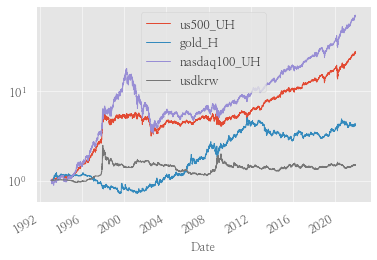

In [6]:
price_df.rebase(1).plot(logy=True)

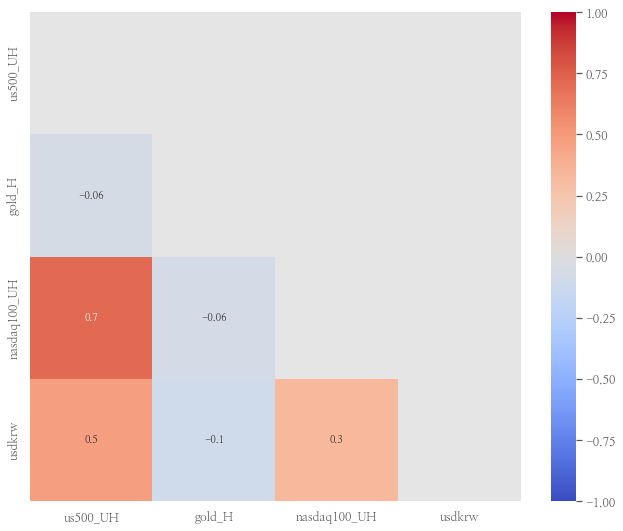

In [7]:
plot_correlations(price_df)

In [8]:
class WeighLAA(bt.Algo):
    def __init__(self, signal_name):
        super(WeighLAA, self).__init__()
        self.signal_name = signal_name

    def is_berish_and_depression(self, signal):
        return signal == True

    def current_weights(self, target):
        weights = pd.Series()
        for cname in target.children:
            c = target.children[cname]
            weights[cname] = c.weight
        return weights

    def __call__(self, target):
        t0 = target.now
        weights = self.current_weights(target) # 한국형으로 가지고 있다.
        # print(t0, weights.index, weights.values)
        signal = target.get_data(self.signal_name)
        if self.is_berish_and_depression(signal.loc[t0].values[0]): # SHY
            if 'nasdaq100_UH' in weights.index:
                if weights['nasdaq100_UH'] != 0.0: # QQQ에 투자중이라면
                    weights['usdkrw'] = weights['nasdaq100_UH']

                weights.drop(labels=['nasdaq100_UH'], inplace=True)
        else: # QQQ
            if 'usdkrw' in weights.index:
                if weights['usdkrw'] != 0: # SHY에 투자 중이라면
                    weights['nasdaq100_UH'] = weights['usdkrw']

                weights.drop(labels=['usdkrw'], inplace=True)

        # 1년 한번 전체 비중을 맞춘다.
        if t0.month == 12:
            for name in weights.index:
                weights[name] = 0.3333 # 3가지 자산이다. IEF 없다.

        target.temp['weights'] = weights
        # print(f'{t0} {weights}')
        return True

In [10]:
class SelectAsset(bt.Algo):
    def __init__(self, signal_name):
        super(SelectAsset, self).__init__()
        self.signal_name = signal_name

    def is_berish_and_depression(self, signal):
        return signal == True

    def __call__(self, target):
        t0 = target.now
        signal = target.get_data(self.signal_name)

        if self.is_berish_and_depression(signal.loc[t0].values[0]):
            target.temp["selected"] = ['us500_UH', 'gold_H', 'usdkrw']
        else:
            target.temp["selected"] = ['us500_UH', 'gold_H',  'nasdaq100_UH']

        weights = pd.Series()
        for name in target.temp["selected"]:
            weights[name] = 0.3333 # 3가지 자산이다. IEF 없다.

        target.temp['weights'] = weights
        return True

In [11]:
START_DATE='1993-01-29'#'2004-11-18'
once = bt.AlgoStack(#bt.algos.RunAfterDate('2004-11-29'),
                    bt.algos.RunOnce(),
                    bt.algos.PrintDate(),
                    SelectAsset('Growth_Trend'),
                    bt.algos.PrintTempData(),
                    bt.algos.Rebalance())
laa = bt.AlgoStack(
    bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=True),
    bt.algos.PrintDate(),
    bt.algos.SelectAll(),
    WeighLAA('Growth_Trend'),
    # bt.algos.PrintTempData(),
    bt.algos.Rebalance()
)
st = bt.Strategy("LAA",
    [
        bt.algos.Or([once, laa])
    ])

In [19]:
bt_laa = bt.Backtest(st, price_df, additional_data={'Growth_Trend':signal[['berish']]}, initial_capital=10000000)
bt_iwd = long_only_ew(price_df[['us500_UH']], 'us500_UH', START_DATE)
bt_gld = long_only_ew(price_df[['gold_H']], 'gold_H', START_DATE)
bt_shy = long_only_ew(price_df[['usdkrw']], 'usdkrw', START_DATE)
bt_qqq = long_only_ew(price_df[['nasdaq100_UH']], 'nasdaq100_UH', START_DATE)

In [20]:
r_all = bt.run(bt_iwd, bt_gld, bt_shy, bt_qqq, bt_laa)
r = bt.run(bt_laa)

1993-01-29 00:00:00
{'selected': ['us500_UH', 'gold_H', 'nasdaq100_UH'], 'weights': us500_UH       0.333
gold_H         0.333
nasdaq100_UH   0.333
dtype: float64}
1993-01-30 00:00:00
1993-02-27 00:00:00
1993-03-31 00:00:00
1993-04-30 00:00:00
1993-05-31 00:00:00
1993-06-30 00:00:00
1993-07-31 00:00:00
1993-08-31 00:00:00
1993-09-28 00:00:00
1993-10-30 00:00:00
1993-11-30 00:00:00
1993-12-28 00:00:00
1994-01-31 00:00:00
1994-02-28 00:00:00
1994-03-31 00:00:00
1994-04-30 00:00:00
1994-05-31 00:00:00
1994-06-30 00:00:00
1994-07-30 00:00:00
1994-08-31 00:00:00
1994-09-30 00:00:00
1994-10-31 00:00:00
1994-11-30 00:00:00
1994-12-28 00:00:00
1995-01-28 00:00:00
1995-02-28 00:00:00
1995-03-31 00:00:00
1995-04-29 00:00:00
1995-05-31 00:00:00
1995-06-30 00:00:00
1995-07-31 00:00:00
1995-08-31 00:00:00
1995-09-30 00:00:00
1995-10-31 00:00:00
1995-11-30 00:00:00
1995-12-27 00:00:00
1996-01-31 00:00:00
1996-02-29 00:00:00
1996-03-30 00:00:00
1996-04-30 00:00:00
1996-05-31 00:00:00
1996-06-29 00:00:

In [21]:
r_all.prices['2002-2-1':].calc_stats().display()

Stat                 us500_UH    gold_H      usdkrw      nasdaq100_UH    LAA
-------------------  ----------  ----------  ----------  --------------  ----------
Start                2002-02-01  2002-02-01  2002-02-01  2002-02-01      2002-02-01
End                  2021-12-03  2021-12-03  2021-12-03  2021-12-03      2021-12-03
Risk-free rate       0.00%       0.00%       0.00%       0.00%           0.00%

Total Return         431.34%     417.36%     -10.10%     885.28%         747.63%
Daily Sharpe         0.53        0.56        0.00        0.62            1.00
Daily Sortino        0.86        0.91        0.00        1.02            1.64
CAGR                 8.79%       8.64%       -0.54%      12.22%          11.38%
Max Drawdown         -39.88%     -44.91%     -35.74%     -51.23%         -21.19%
Calmar Ratio         0.22        0.19        -0.01       0.24            0.54

MTD                  -1.22%      -1.16%      -0.23%      -2.53%          -1.70%
3m                   2.85%       -

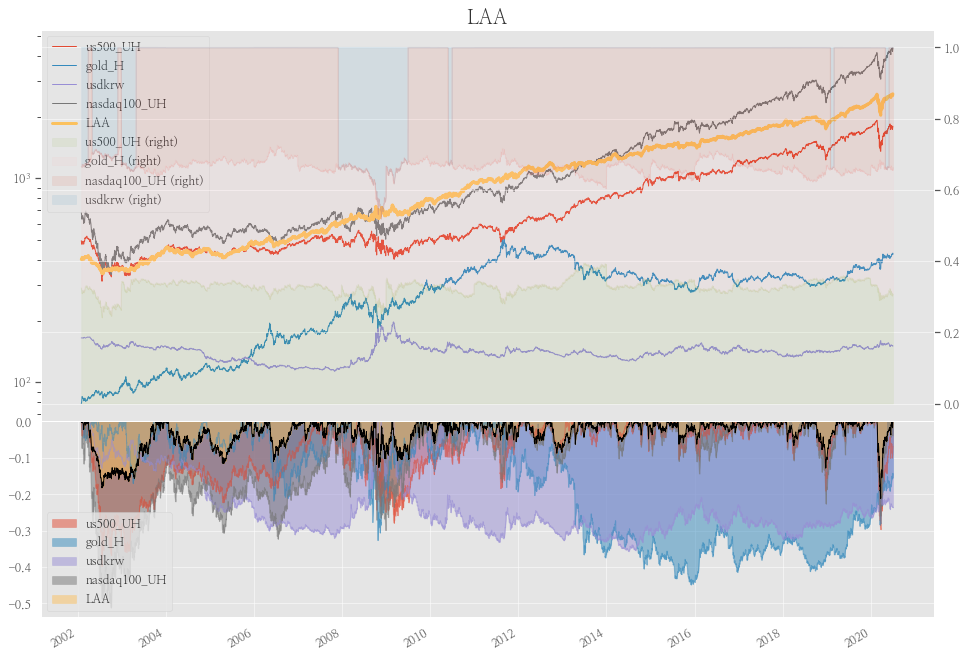

In [22]:
plot_assets(r_all, '2002-2-1', '2020-7-2', 'LAA')

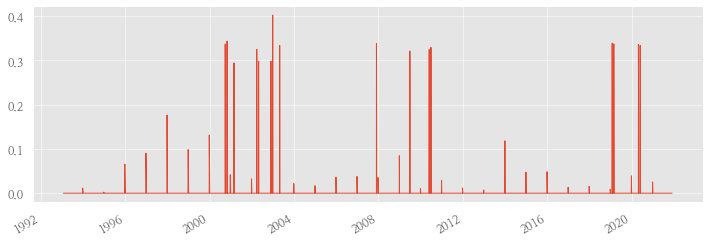

In [23]:
bt_laa.turnover.plot(figsize=(12,4));

In [24]:
r.display_monthly_returns()

  Year    Jan     Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct    Nov    Dec     YTD
------  -----  ------  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  ------
  1993  -0      -1.62   2.38  -0.88   6.75  -0.23   1.26  -0.03  -0.31   2.09  -0.57   2.88   12.06
  1994   1.65   -0.95  -3.14  -1.62   1.73  -2.53   1.61   3.68  -0.59   1.71  -2.58  -0.3    -1.59
  1995   1.08    3.07   1.43   2.05   1.85   4.6    2.76   2.08   1.63   0.4    2.07  -0.21   25.24
  1996   4.32    1.35  -0.5    2.6    3.02   0.81  -3.33   2.87   5.94   1.86   6.43   1.42   29.86
  1997   4.03   -1.21  -2.28   4.35   6.09   0.09   8.09  -2.11   3.9   -1.06  18.53  17.59   68.66
  1998   7.32   11.12  -8.52  -0.14  -0.69   4.3   -7.37  -7     13.32   0.17   2.11   5.33   18.7
  1999   4.75   -1.71   4.01   0.17  -3.29   2.49   0.81   0.29   6.91   4.09   2.25   8.75   33.01
  2000  -3.27    7.87   0.37  -6.25  -3.98   6.09  -3.19   5.71  -6.04  -0.07  -6.34   1.73   -8.43
 

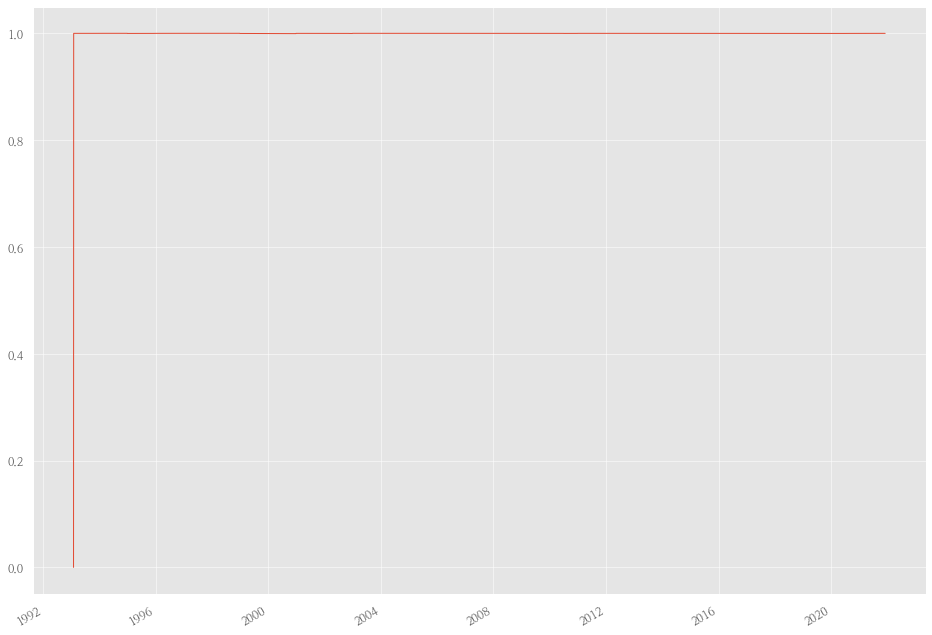

In [25]:
r.get_security_weights().sum(axis=1).plot();

In [26]:
trade = r.backtest_list[0].positions.diff(1)
trade = trade[START_DATE:]
# trade[trade.values.sum(axis=1) != 0].to_csv('laa_korea_trade.csv') #실제 매매가 일어난 날만 출력
trade[trade.values.sum(axis=1) != 0]
len(trade[trade.values.sum(axis=1) != 0])

,us500_UH,gold_H,nasdaq100_UH,usdkrw
1993-01-29,6390.000,1135.000,2642.000,0.000
1993-12-28,14.000,-38.000,89.000,0.000
1994-12-28,14.000,5.000,-20.000,0.000
1995-12-27,-393.000,271.000,-316.000,0.000
1996-12-27,-341.000,512.000,-419.000,0.000
1997-12-27,-1392.000,2118.000,-336.000,0.000
1998-12-28,498.000,948.000,-375.000,0.000
1999-12-28,794.000,1666.000,-358.000,0.000
2000-09-29,0.000,0.000,-907.000,13880.000
2000-10-31,0.000,0.000,986.000,-13880.000


44

In [28]:
pd.set_option('max_rows', None)
r.get_transactions('LAA')

price   quantity
Date       Security                         
1993-01-29 gold_H        2935.916   1135.000
           nasdaq100_UH  1261.438   2642.000
           us500_UH       521.516   6390.000
1993-12-28 gold_H        3404.582    -38.000
           nasdaq100_UH  1367.436     89.000
           us500_UH       583.120     14.000
1994-12-28 gold_H        3333.216      5.000
           nasdaq100_UH  1355.507    -20.000
           us500_UH       572.658     14.000
1995-12-27 gold_H        3352.488    271.000
           nasdaq100_UH  1921.434   -316.000
           us500_UH       763.997   -393.000
1996-12-27 gold_H        3170.675    512.000
           nasdaq100_UH  3023.956   -419.000
           us500_UH      1051.583   -341.000
1997-12-27 gold_H        2518.491   2118.000
           nasdaq100_UH  6145.955   -336.000
           us500_UH      2349.000  -1392.000
1998-12-28 gold_H        2416.956    948.000
           nasdaq100_UH  9453.414   -375.000
           us500_UH      2498.125    498.000
1999-12-28 gold_H        2405.654   1666.000
           nasdaq100_UH 17533.892   -358.000
           us500_UH      2850.454    794.000
2000-09-29 nasdaq100_UH 17065.769   -907.000
           usdkrw        1115.150  13880.000
2000-10-31 nasdaq100_UH 16002.205    986.000
           usdkrw        1137.500 -13880.000
2000-12-26 gold_H        2270.122   -196.000
           nasdaq100_UH 12905.774    143.000
           us500_UH      2857.530   -483.000
2001-02-28 nasdaq100_UH 10256.084  -1129.000
           usdkrw        1253.950   9234.000
2001-12-28 gold_H        2280.355   -510.000
           us500_UH      2669.861    -53.000
           usdkrw        1318.000    993.000
2002-03-29 nasdaq100_UH  8224.868   1642.000
           usdkrw        1320.900 -10227.000
2002-04-30 nasdaq100_UH  7055.337  -1642.000
           usdkrw        1289.000   8987.000
2002-11-29 nasdaq100_UH  5753.932   1878.000
           usdkrw        1202.850  -8987.000
2002-12-30 gold_H        2837.874  -1710.000
           nasdaq100_UH  5078.875  -1878.000
           us500_UH      1871.122   1324.000
           usdkrw        1197.100   9960.000
2003-04-30 nasdaq100_UH  5757.400   2101.000
           usdkrw        1214.500  -9960.000
2003-12-30 gold_H        3355.005    293.000
           nasdaq100_UH  7543.824   -103.000
           us500_UH      2400.043    -89.000
2004-12-30 gold_H        3482.350   -215.000
           nasdaq100_UH  7248.218     57.000
           us500_UH      2318.035    145.000
2005-12-29 gold_H        4101.680   -419.000
           nasdaq100_UH  7169.336    153.000
           us500_UH      2365.418    265.000
2006-12-28 gold_H        4947.202   -395.000
           nasdaq100_UH  7009.182    237.000
           us500_UH      2518.002    115.000
2007-11-30 nasdaq100_UH  8247.831  -2445.000
           usdkrw         921.150  21892.000
2007-12-28 gold_H        6459.962   -313.000
           us500_UH      2674.112    806.000
           usdkrw         936.000   -138.000
2008-12-30 gold_H        6724.365     97.000
           us500_UH      2225.816   2201.000
           usdkrw        1259.550  -4408.000
2009-06-30 nasdaq100_UH  8071.350   2739.000
           usdkrw        1274.800 -17346.000
2009-12-30 gold_H        8371.077    -98.000
           nasdaq100_UH  9398.530     67.000
           us500_UH      2669.090     68.000
2010-05-31 nasdaq100_UH  9543.999  -2806.000
           usdkrw        1202.120  22277.000
2010-06-30 nasdaq100_UH  9118.007   2988.000
           usdkrw        1223.250 -22277.000
2010-12-30 gold_H       10780.000   -193.000
           nasdaq100_UH 10901.000    -63.000
           us500_UH      2946.188    942.000
2011-12-29 gold_H       11880.000   -101.000
           nasdaq100_UH 11379.000     58.000
           us500_UH      3087.074    172.000
2012-12-28 gold_H       12815.000    -20.000
           nasdaq100_UH 12370.000    -44.000
           us500_UH      3232.963    250.000
2013-12-31 gold_H        9340.000   1561.000
           nasdaq100_UH

2021-12-03 00:00:00
2020-12-03 00:00:00


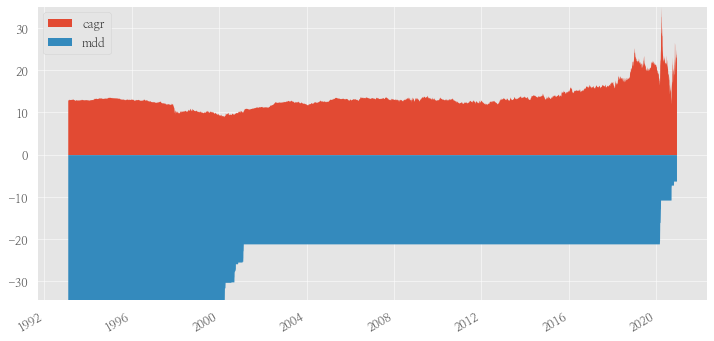

In [29]:
투자진입시점별CAGRMDD(bt_laa)

In [30]:
r.backtests['LAA'].stats.drawdown_details.sort_values('drawdown').head(20)

,Start,End,Length,drawdown
145,2000-03-27 00:00:00,2007-01-12 00:00:00,2482,-0.345
123,1997-12-24 00:00:00,1999-03-05 00:00:00,436,-0.223
355,2020-02-21 00:00:00,2020-06-23 00:00:00,123,-0.212
122,1997-12-12 00:00:00,1997-12-23 00:00:00,11,-0.144
327,2018-10-05 00:00:00,2019-04-03 00:00:00,180,-0.129
181,2008-10-09 00:00:00,2009-02-20 00:00:00,134,-0.127
183,2009-02-25 00:00:00,2009-09-10 00:00:00,197,-0.108
362,2020-09-03 00:00:00,2021-02-09 00:00:00,159,-0.108
128,1999-04-13 00:00:00,1999-07-16 00:00:00,94,-0.099
116,1997-10-10 00:00:00,1997-11-17 00:00:00,38,-0.094


In [31]:
r.backtests['LAA'].stats.drawdown_details.sort_values(by="Length", ascending=False).head(20)

,Start,End,Length,drawdown
145,2000-03-27 00:00:00,2007-01-12 00:00:00,2482,-0.345
123,1997-12-24 00:00:00,1999-03-05 00:00:00,436,-0.223
22,1994-01-18 00:00:00,1995-02-10 00:00:00,388,-0.087
240,2012-09-24 00:00:00,2013-04-10 00:00:00,198,-0.088
183,2009-02-25 00:00:00,2009-09-10 00:00:00,197,-0.108
275,2015-08-19 00:00:00,2016-02-18 00:00:00,183,-0.063
327,2018-10-05 00:00:00,2019-04-03 00:00:00,180,-0.129
362,2020-09-03 00:00:00,2021-02-09 00:00:00,159,-0.108
234,2012-03-28 00:00:00,2012-08-23 00:00:00,148,-0.062
319,2018-01-30 00:00:00,2018-06-15 00:00:00,136,-0.067


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               1993-01-29  1993-01-29
End Period                 2021-12-03  2021-12-03
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      94.0%

Cumulative Return          3,303.07%   925.59%
CAGR﹪                     13.0%       8.4%

Sharpe                     0.9         0.52
Smart Sharpe               0.89        0.52
Sortino                    1.34        0.74
Smart Sortino              1.32        0.73
Sortino/√2                 0.95        0.52
Smart Sortino/√2           0.93        0.51
Omega                      1.2         1.2

Max Drawdown               -34.53%     -56.78%
Longest DD Days            2482        2620
Volatility (ann.)          14.45%      18.34%
R^2                        0.23        0.23
Calmar                     0.38        0.15
Skew                       0.22        -0.2
Kurtosis                   25.07       11.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2000-03-27,2002-07-23,2007-01-12,2482,-34.531,-32.755
2,1997-12-24,1998-08-31,1999-03-05,436,-22.300,-19.436
3,2020-02-21,2020-03-23,2020-06-23,123,-21.185,-19.117
4,1997-12-12,1997-12-16,1997-12-23,11,-14.386,-12.106
5,2018-10-05,2018-12-24,2019-04-03,180,-12.882,-11.552


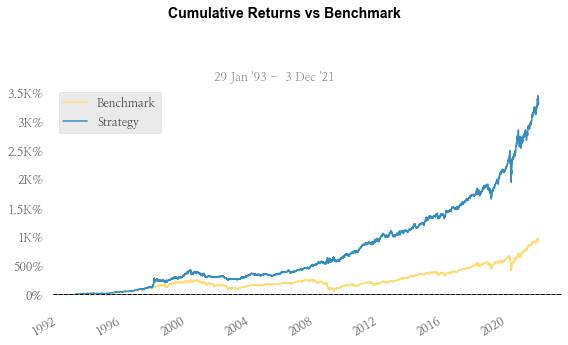

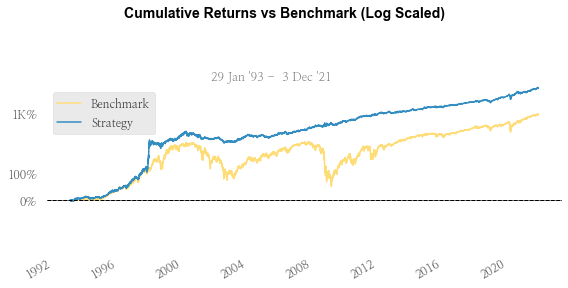

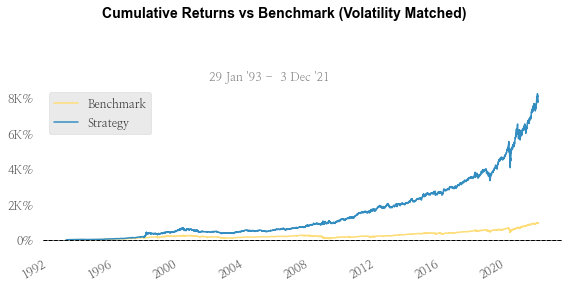

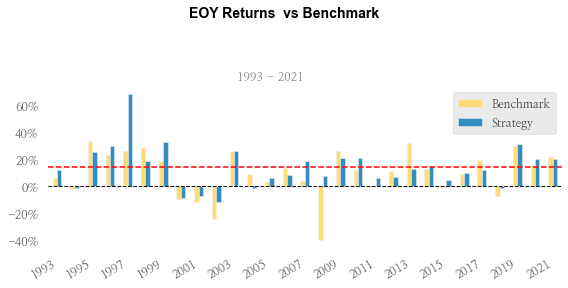

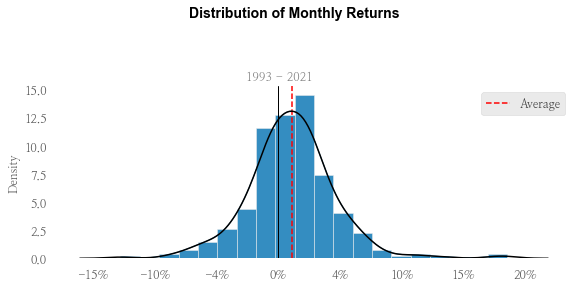

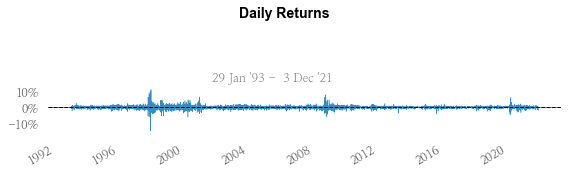

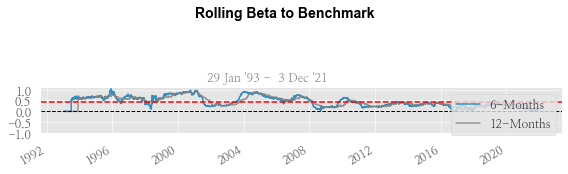

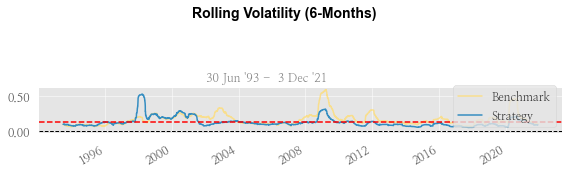

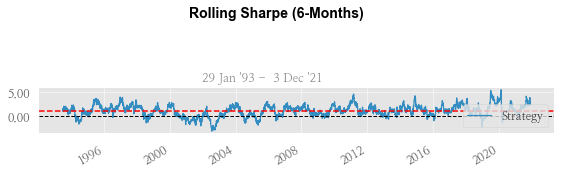

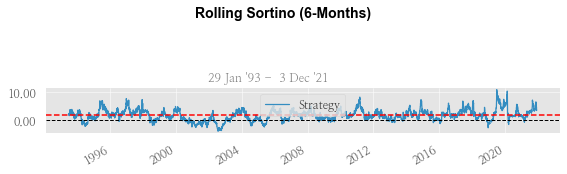

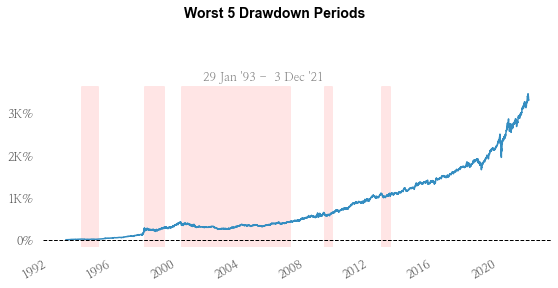

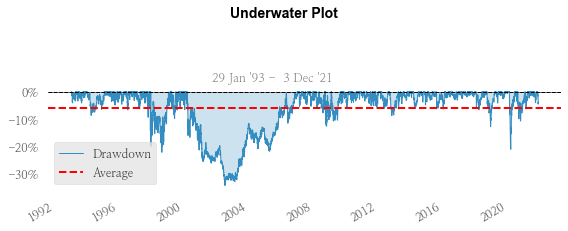

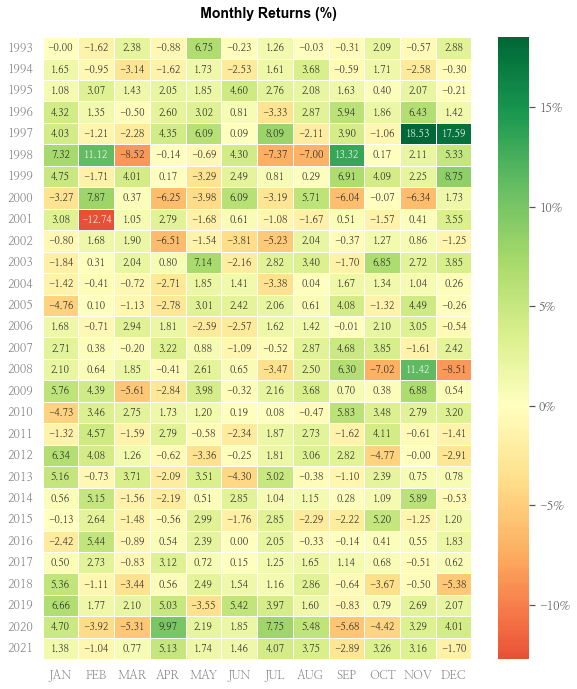

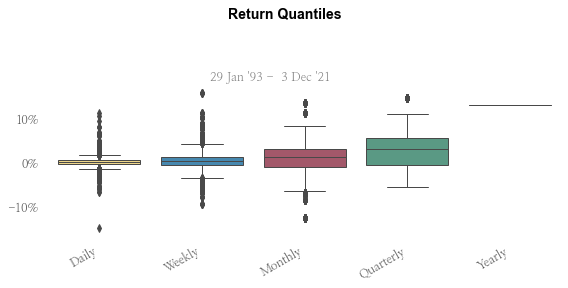

In [32]:
qs.reports.full(r.prices['LAA'].to_returns().dropna(), us500.loc[START_DATE:, 'US500'].to_returns().dropna())